# Expression Quality Control (Part 1)
This is a template notebook for performing preliminary quality control on your organism's expression data.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
from os import path
import ipywidgets as widgets

### Merge output data to generate input for anlaysis

Enter path of log-TPM, MultiQC, and metadata files here

In [2]:
sns.set_style('ticks')
#Specify input data needed
species = 'Synechococcus_sp_PCC_7002'
log_TPM_filename = 'log_tpm.csv'
multiqc_filename = 'multiqc_stats.tsv'
metadata_filename = 'metadata.tsv'
target_files = [log_TPM_filename, multiqc_filename, metadata_filename]

In [5]:
output_dr =  path.join('Species', species, 'nf_results')

log_tpm_dfs = []
multiqc_dfs = []
metadata_dfs = []

display_text_style = '<b>%s</b>'

print('Parsing input files:')
for subdir, dirs, files in os.walk(output_dr):
    for file in files:
        filepath = path.join(subdir, file)
        print(filepath)
        file_of_interest = [target_file for target_file in target_files if target_file in filepath]
        
        if file_of_interest:
        
            if file_of_interest[0] == log_TPM_filename:
                print(filepath)
                df = pd.read_csv(filepath, index_col=0).fillna(0)
                log_tpm_dfs.append(df)

            if file_of_interest[0] == multiqc_filename:
                print(filepath)
                df = pd.read_csv(filepath, index_col=0, sep='\t')
                multiqc_dfs.append(df)

            if file_of_interest[0] == metadata_filename:
                print(filepath)
                df = pd.read_csv(filepath, index_col=0, sep='\t')
                metadata_dfs.append(df)

DF_log_tpm = pd.concat(log_tpm_dfs, axis=1).fillna(0)
display(widgets.HTML(display_text_style % 'INPUT OF EXPRESSION DATA'))
print('Number of genes:',DF_log_tpm.shape[0])
print('Number of samples:',DF_log_tpm.shape[1])
display(DF_log_tpm.head())

DF_qc_stats = pd.concat(multiqc_dfs)
display(widgets.HTML(display_text_style % 'INPUT OF QC DATA'))
display(widgets.HTML('There may be some datasets that failed along the processing pipeline, so the number of samples with QC data may be higher than the number of samples with expression data.'))
print('Number of samples with QC data:',DF_qc_stats.shape[0])
display(DF_qc_stats.head())

DF_metadata = pd.concat(metadata_dfs)
display(widgets.HTML(display_text_style % 'INPUT OF METADATA'))
print('Number of samples with metadata:',DF_metadata.shape[0])
display(DF_metadata.head())

Parsing input files:


ValueError: No objects to concatenate

### Remove extra sample rows

Ensure that metadata and qc_stats data contain all log_tpm sample information.

In [31]:
assert(set(DF_log_tpm.columns) - set(DF_metadata.index) == set())
assert(set(DF_log_tpm.columns) - set(DF_qc_stats.index) == set())

In [32]:
DF_metadata = DF_metadata.loc[DF_log_tpm.columns]
DF_qc_stats = DF_qc_stats.loc[DF_log_tpm.columns]

## Check QC statistics

### FastQC quality control

In [33]:
fastqc_cols = ['per_base_sequence_quality',
              #'per_tile_sequence_quality',
               'per_sequence_quality_scores',
               'per_base_sequence_content',
               'per_sequence_gc_content',
               'per_base_n_content',
               'sequence_length_distribution',
               'sequence_duplication_levels',
               'overrepresented_sequences',
               'adapter_content']

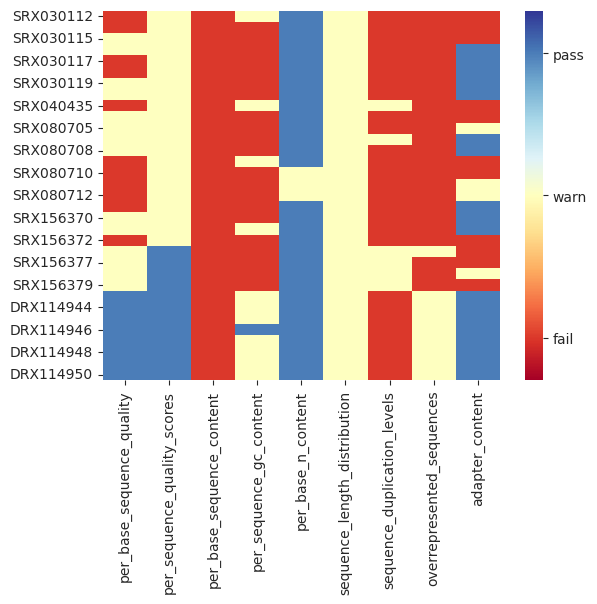

In [34]:
DF_fastqc = DF_qc_stats[fastqc_cols]
ax = sns.heatmap(DF_fastqc.replace('pass',1).replace('warn',0).replace('fail',-1),
            cmap='RdYlBu',vmax=1.3,vmin=-1.3)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['fail','warn','pass'])

The following four categories are the most important:
* per_base_sequence_quality
* per_sequence_quality_scores
* per_base_n_content
* adapter_content
    
If a sample does not pass any of these four categories, discard the sample.

In [35]:
fastqc_fail_cols = ['per_base_sequence_quality',
                    'per_sequence_quality_scores',
                    'per_base_n_content',
                    'adapter_content']

In [36]:
DF_failed_fastqc = DF_fastqc[fastqc_fail_cols][(DF_fastqc[fastqc_fail_cols] != 'pass').any(axis=1)]
print('Number of samples not meeting the quality criteria:', len(DF_failed_fastqc))
DF_failed_fastqc[fastqc_fail_cols]

Number of samples not meeting the quality criteria: 25


,per_base_sequence_quality,per_sequence_quality_scores,per_base_n_content,adapter_content
SRX030112,fail,warn,pass,fail
SRX030114,fail,warn,pass,fail
SRX030115,warn,warn,pass,fail
SRX030116,warn,warn,pass,pass
SRX030117,fail,warn,pass,pass
SRX030118,fail,warn,pass,pass
SRX030119,warn,warn,pass,pass
SRX030120,warn,warn,pass,pass
SRX040435,fail,warn,pass,fail
SRX080704,warn,warn,pass,fail


Mark samples that passed.

In [37]:
DF_metadata['passed_fastqc'] = ~DF_metadata.index.isin(DF_failed_fastqc.index)
DF_pass_fastqc = DF_fastqc[fastqc_fail_cols][(DF_fastqc[fastqc_fail_cols] == 'pass').all(axis=1)]
print('Number of samples meeting the quality criteria:', len(DF_pass_fastqc))
DF_pass_fastqc

Number of samples meeting the quality criteria: 8


,per_base_sequence_quality,per_sequence_quality_scores,per_base_n_content,adapter_content
DRX114943,pass,pass,pass,pass
DRX114944,pass,pass,pass,pass
DRX114945,pass,pass,pass,pass
DRX114946,pass,pass,pass,pass
DRX114947,pass,pass,pass,pass
DRX114948,pass,pass,pass,pass
DRX114949,pass,pass,pass,pass
DRX114950,pass,pass,pass,pass


### Number of aligned reads

The following histogram shows how many reads map to coding sequences (i.e. mRNA). Too few aligned reads reduces the sensitivity of the resulting data.

In [38]:
min_mrna_reads = 500000 # Minimum number of reads mapped to mRNA (500,000)

Text(0.5, 1.0, 'Number of reads mapped to CDS')

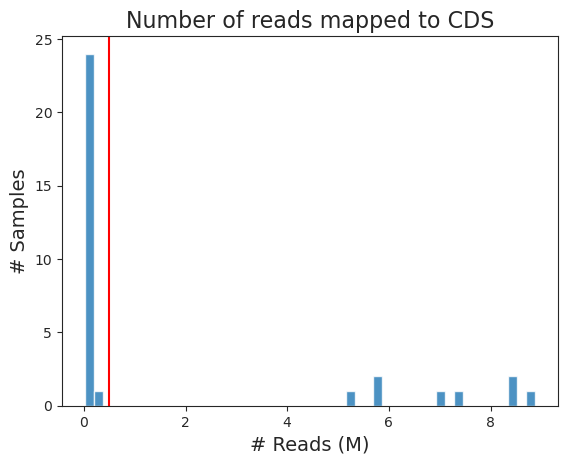

In [39]:
fig,ax = plt.subplots()
ax.hist(DF_qc_stats['Assigned']/1e6,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_mrna_reads/1e6,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('# Reads (M)',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Number of reads mapped to CDS',fontsize=16)

Identify samples with poor read depth:

In [40]:
DF_failed_mrna = DF_qc_stats[DF_qc_stats['Assigned'] < min_mrna_reads].sort_values('Assigned')
DF_failed_mrna

,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,Unassigned_Duplicate,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,se_sense,se_antisense,failed,pe_sense,pe_antisense
SRX030115,11754562,13171,8,11721922,0,0,0,0,0,0,...,16842005,842100250,293910098,541148579,35.738224,0.1274,0.6461,0.2265,NaN,NaN
SRX040435,12695697,13302,6,12642674,0,0,0,0,0,0,...,34338802,1716940100,1118029582,591492041,65.549640,0.0988,0.6386,0.2626,NaN,NaN
SRX156379,12019224,20800,7,11981012,0,0,0,0,0,0,...,17378142,868907100,292293167,564815831,34.996983,0.7078,0.2040,0.0882,NaN,NaN
SRX156378,9430252,22772,6,9389555,0,0,0,0,0,0,...,11490540,574527000,126006563,443594304,22.789651,0.7403,0.1552,0.1045,NaN,NaN
SRX030120,12708707,25156,9,12651329,0,0,0,0,0,0,...,20220020,1011001000,407136110,594351943,41.211538,0.0956,0.2529,0.6515,NaN,NaN
SRX030112,10774458,26065,11,10719891,0,0,0,0,0,0,...,15512068,775603400,278164074,490502714,36.758566,0.1001,0.4508,0.4491,NaN,NaN
SRX080710,19129963,29743,3,19054608,0,0,0,0,0,0,...,30047553,1502377650,606385983,885638088,41.050901,0.3903,0.1061,0.5036,NaN,NaN
SRX080712,18991719,30706,13,18929450,0,0,0,0,0,0,...,30729130,1536456500,655045034,870688539,43.331390,0.6262,0.1120,0.2619,NaN,NaN
SRX030119,16535242,33101,10,16478105,0,0,0,0,0,0,...,26691541,1334577050,553009747,771109742,42.220665,0.1051,0.6369,0.2580,NaN,NaN
SRX080705,17387443,38889,9,17335630,0,0,0,0,0,0,...,26430653,1321532650,501352058,809853391,38.718624,0.3743,0.2429,0.3829,NaN,NaN


Mark samples that passed.

In [41]:
DF_metadata['passed_reads_mapped_to_CDS'] = ~DF_metadata.index.isin(DF_failed_mrna.index)

### Examine Global Correlations

Only examine data that passed the first two steps.

In [42]:
metadata_passed_step2 = DF_metadata[DF_metadata[['passed_fastqc','passed_reads_mapped_to_CDS']].all(axis=1)]
DF_log_tpm_passed_step2 = DF_log_tpm[metadata_passed_step2.index]
DF_log_tpm_passed_step2

,DRX114943,DRX114944,DRX114945,DRX114946,DRX114947,DRX114948,DRX114949,DRX114950
Geneid,,,,,,,,
SYNPCC7002_RS15225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SYNPCC7002_RS15230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SYNPCC7002_RS15235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SYNPCC7002_RS15240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SYNPCC7002_RS15245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
SYNPCC7002_RS15210,2.314563,2.072495,2.912742,3.441274,2.468628,2.946795,2.517449,2.630158
SYNPCC7002_RS15215,1.658674,0.674723,2.309849,2.887484,1.278051,1.561857,1.504000,1.302732
SYNPCC7002_RS16580,1.056393,1.552281,2.632866,3.109149,1.504484,1.562824,1.109260,1.915990


A clustermap is a great way to visualize the global correlations between one sample and all others. The ``global_clustering`` function uses hierarchical clustering to identify specific clusters in the clustermap. The optional arguments are:

* ``threshold``: Threshold used to extract clusters from the hierarchy. To increase the number of clusters, decrease the value of ``threshold``. To decrease the number of clusters, increase the value of ``threshold`` (default: 0.3)
* ``figsize``: A tuple describing the length and width of the final clustermap. A larger figsize can make x and y-axis labels clearer.
* ``xticklabels``: Show NCBI SRA accession numbers on the x-axis
* ``yticklabels``: Show NCBI SRA accession numbers on the y-axis

In [43]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches

def global_clustering(data, threshold=0.3, xticklabels=False, yticklabels=False, figsize=(9,9)):
    
    # Retrieve clusters using fcluster 
    corr = data.corr()
    corr.fillna(0,inplace=True)
    dist = sch.distance.pdist(corr)
    link = sch.linkage(dist, method='complete')
    clst = pd.DataFrame(index=data.columns)
    clst['cluster'] = sch.fcluster(link, threshold * dist.max(), 'distance')

    # Get colors for each cluster
    cm = plt.cm.get_cmap('tab20')
    cluster_colors = dict(zip(clst.cluster.unique(), cm.colors))
    clst['color'] = clst.cluster.map(cluster_colors)

    print('Number of cluster: ', len(cluster_colors))
    
    legend_items = [patches.Patch(color=c, label=l) for l,c in cluster_colors.items()]
    
    sns.set(rc={'figure.facecolor':'white'})
    
    clst_map = sns.clustermap(data.corr(), 
                              figsize=figsize, 
                              row_linkage=link, 
                              col_linkage=link, 
                              col_colors=clst.color,
                              yticklabels=yticklabels, 
                              xticklabels=xticklabels,
                              vmin=0, 
                              vmax=1)
    
    legend = clst_map.ax_heatmap.legend(loc='upper left', 
                                        bbox_to_anchor=(1.01,0.85), 
                                        handles=legend_items,
                                        frameon=True)
    
    legend.set_title(title='Clusters',prop={'size':10})
    
    return clst['cluster']

Number of cluster:  2


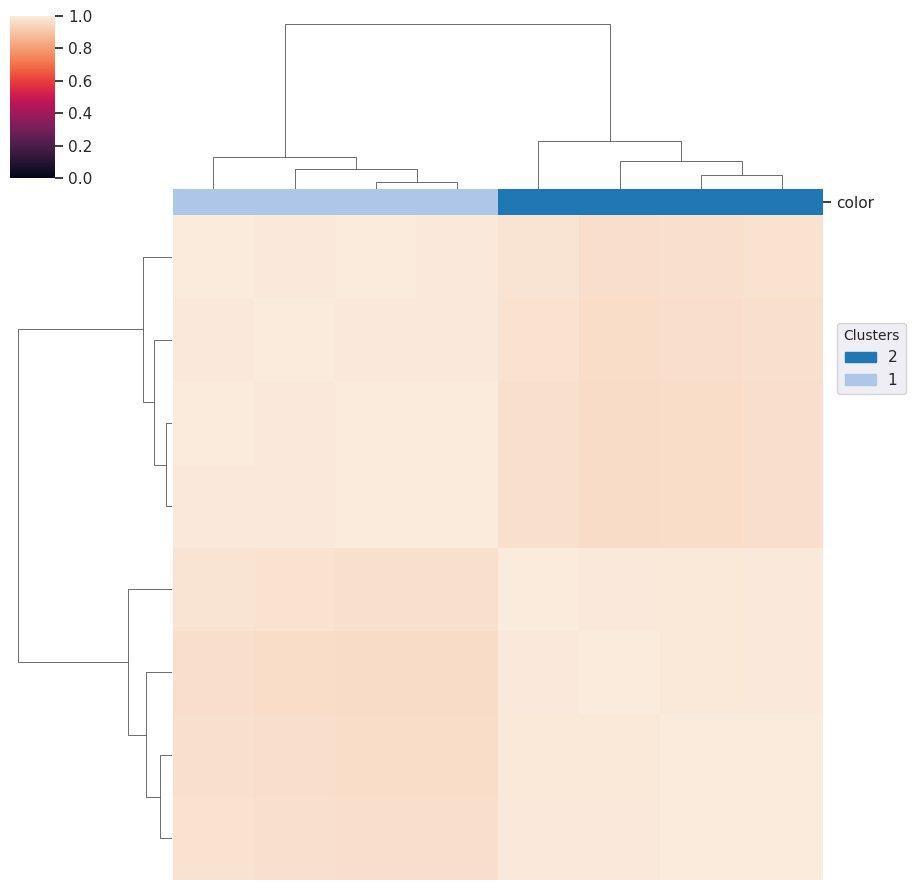

In [47]:
clusters = global_clustering(DF_log_tpm_passed_step2)

Select clusters to remove.

In [48]:
remove_clusters = []
passed_global_corr = clusters[~clusters.isin(remove_clusters)].index

In [52]:
passed_global_corr

Index(['DRX114943', 'DRX114944', 'DRX114945', 'DRX114946', 'DRX114947',
       'DRX114948', 'DRX114949', 'DRX114950'],
      dtype='object')

The following code can be adapted to see the NCBI SRA accession for samples in each cluster.

In [49]:
clusters[clusters == 1]

DRX114945    1
DRX114946    1
DRX114948    1
DRX114950    1
Name: cluster, dtype: int32

Re-cluster samples to ensure all outliers were removed.

In [24]:
DF_log_tpm_passed_step3 = DF_log_tpm[passed_global_corr]

Number of cluster:  10


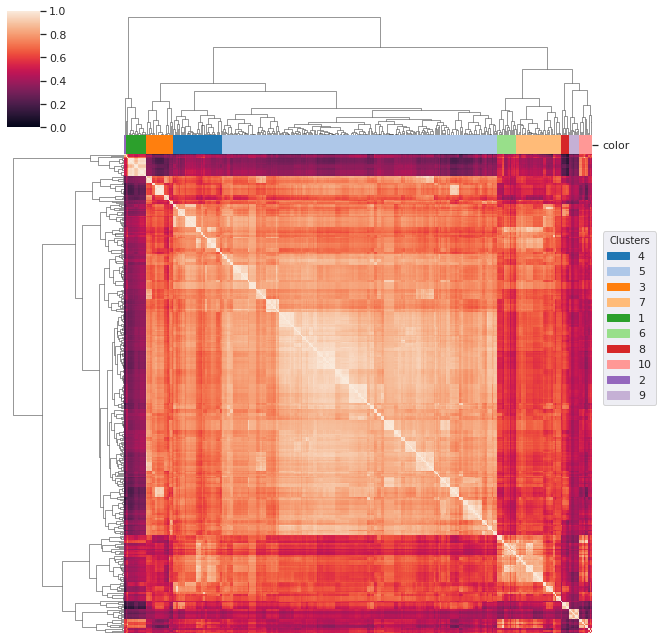

In [25]:
clusters = global_clustering(DF_log_tpm_passed_step3)

Once you are satisfied with your dataset, mark the samples that passed the global correlation

In [56]:
DF_metadata['passed_global_correlation'] = DF_metadata.index.isin(passed_global_corr)

In [57]:
DF_metadata.head()

,SRX030112,SRX030114,SRX030115,SRX030116,SRX030117,SRX030118,SRX030119,SRX030120,SRX040435,Unnamed: 10,...,Submission,dbgap_study_accession,Consent,RunHash,ReadHash,R1,R2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation
SRX030112,SRR097642,2011-02-07 18:45:41,2014-05-29 21:17:32,15512068.0,7.756034e+08,0.0,50.0,648.0,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
SRX030114,SRR097643,2011-02-07 18:45:41,2014-05-29 21:21:09,34204786.0,1.710239e+09,0.0,50.0,1431.0,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
SRX030115,SRR097644,2011-02-07 18:45:41,2014-05-29 21:18:06,16842005.0,8.421002e+08,0.0,50.0,703.0,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
SRX030116,SRR097645;SRR097646;SRR097647,2011-02-07 18:45:41,2014-05-29 21:24:05,47735646.0,2.386782e+09,0.0,50.0,2008.0,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
SRX030117,SRR097648,2011-02-07 18:45:41,2014-05-29 21:21:46,26488336.0,1.324417e+09,0.0,50.0,1112.0,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


# Remove failed samples

In [58]:
qc_columns = ['passed_fastqc',
              'passed_reads_mapped_to_CDS',
              'passed_global_correlation']

In [59]:
pass_qc = DF_metadata[qc_columns].all(axis=1)
DF_metadata_passed = DF_metadata[pass_qc]

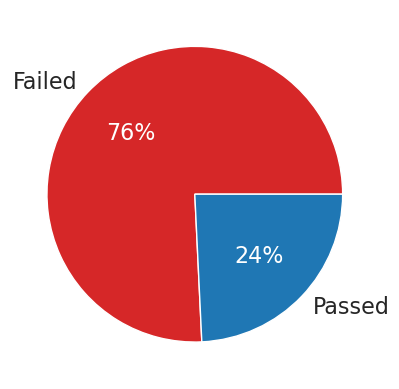

In [60]:
_,_,pcts = plt.pie(pass_qc.value_counts().reindex([False,True]),
        labels = ['Failed','Passed'],
        colors=['tab:red','tab:blue'],
        autopct='%.0f%%',textprops={'size':16});

# Colors percents white
for pct in pcts:
    pct.set_color('white')

WE DO NOT PROCEED WITH THIS ORGANISM AS THERE ARE FEW SAMPLES

# Save current metadata

Enter path of interim metadata files here. It is recommended that the ``metadata_qc.tsv`` file is copied to a new ``metadata_qc_curated.tsv`` file before editing. This will prevent this notebook from over-writing any curated metadata.

In [33]:
metadata_all_qc_file = path.join('..', 'data', 'interim', 'metadata_qc_part1_all.tsv') # Enter filename for full metadata QC file
metadata_qc_file = path.join('..', 'data', 'interim', 'metadata_qc_part1.tsv') # Enter filename for metadata QC file with only passing datasets

In [34]:
DF_metadata.to_csv(metadata_all_qc_file, sep='\t')
DF_metadata_passed.to_csv(metadata_qc_file, sep='\t')

# Metadata Curation

The next step is to curate the metadata. At a minimum, three new columns must be added to the metadata sheet:
* ``project``: Nickname for the project. Each bioproject should have a unique project IDs.
* ``condition``: Nickname for the experimental condition. Biological/technical replicates must have identical condition IDs.
* ``reference_condition``: Condition ID of the reference condition. Each project has a single reference condition (See [example metadata sheet](https://github.com/SBRG/nf-rnaseq-bacteria/blob/master/example_data/processed_data/metadata_curated.tsv))

Additional columns may include:
* ``strain_description``: The strain name, and any knock-outs or overexpressed genes
* ``base_media``: Media used (e.g. ``M9``)
* ``carbon_source``: Primary carbon source, with concentration in parentheses (e.g. ``glucose(.4%)``). This is usually empty for undefined media.
* ``nitrogen_source``: Primary nitrogen source, with concentration in parentheses (e.g. ``NH4Cl(1M)``). This is usually empty for undefined media.
* ``aerobicity``: Usually ``aerobic`` or ``anaerobic``
* ``treatment``: Any additional supplements or treatments added to the base media (e.g. ``thiamine(0.1M)`` or ``ampicillin(100ug/mL)``)
* ``temperature``
* ``pH``
* ``OD``: Approximate optical density of cells when selected for library preparation
* ``growth_phase``: e.g. ``mid-exponential`` or ``stationary``
* ``culture_type``: Usually ``batch`` or ``chemostat``
* ``skip``: Whether to skip a sample due to external reasons (e.g. not traditional RNA-seq, distant strain, or lack of metadata)

If specific metadata entries are not reported for a sample, these can be left blank. However, if no metadata can be gleaned from public databases, then we recommend discarding the samples.

Once the metadata has been curated, proceed to [Step 2](https://github.com/avsastry/modulome-workflow/edit/main/3_quality_control/expression_QC_part2.ipynb)